In [106]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DATA_FOLDER = os.path.join("out")
OUTPUT_FOLDER = os.path.join("out", "plots")

def get_dataset_file(cloud_name, timestamp = "latest"):
    # Get all CSV files in the folder
    csv_folder = os.path.join(BASE_DATA_FOLDER, cloud_name)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")
    
    if timestamp == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),
            "%Y-%m-%d-%H:%M:%S"
        ))
        print(f"Loading latest file: {file}")
        return pd.read_csv(file)
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            file_timestamp = filename.split('-')[1:]  # Split to get timestamp part
            file_timestamp = '-'.join(file_timestamp).replace('.csv', '')  # Rebuild timestamp string
            if timestamp == file_timestamp:
                print(f"Loading file: {file}")
                return pd.read_csv(file)
        raise FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")

def output_fig(filename, dataset, cloud):
    output_folder = os.path.join(OUTPUT_FOLDER, dataset, cloud)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plt.savefig(os.path.join(output_folder, filename), dpi=300, bbox_inches='tight')

In [107]:
# Read the file and put into pandas dataframe
CLOUD, DATASET = "Lille_0", "Paris_Lille"
df = get_dataset_file(CLOUD, "latest")

# Convert times to milliseconds
df['mean'] = df['mean'] * 1000
df['stdev'] = df['stdev'] * 1000

Loading latest file: out/Lille_0/Lille_0-2025-01-21-18:09:24.csv


In [108]:
# Plot styling and octree types list and palette
plt.style.use('seaborn')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.axisbelow': True
})

In [109]:
OCTREE_TYPE_PARAMS = ['octree', 'encoder']
# Get unique octree parameters (i.e. the templated variables)
parameter_combinations = (
    df[OCTREE_TYPE_PARAMS]
    .drop_duplicates()
    .sort_values(by=OCTREE_TYPE_PARAMS, ascending=True)
)

# Create color palette and mapping
# palette = sns.color_palette("Paired", len(parameter_combinations))
palette = ["#1984c5", "#63bff0", "#c23728", "#de6e56", "#e1a692"]
color_dict = {
    tuple(row[col] for col in OCTREE_TYPE_PARAMS): color
    for row, color in zip(parameter_combinations.to_dict(orient='records'), palette)
}
print(parameter_combinations)
print(palette)
print(color_dict)

      octree           encoder
96    Linear  HilbertEncoder3D
32    Linear   MortonEncoder3D
128  Pointer  HilbertEncoder3D
64   Pointer   MortonEncoder3D
0    Pointer         Unencoded
['#1984c5', '#63bff0', '#c23728', '#de6e56', '#e1a692']
{('Linear', 'HilbertEncoder3D'): '#1984c5', ('Linear', 'MortonEncoder3D'): '#63bff0', ('Pointer', 'HilbertEncoder3D'): '#c23728', ('Pointer', 'MortonEncoder3D'): '#de6e56', ('Pointer', 'Unencoded'): '#e1a692'}


In [110]:
# Some aux. functions for plot information
def add_execution_details(searches, repeats, points, fig, h_ex=0.93):
    execution_details = [
        f"• {searches:,} searches × {repeats:,} repeats",
        f"• Point clouds: {CLOUD} ({points:,} points)",
    ]
    fig.text(0.10, h_ex,
            '\n'.join(execution_details),
            fontsize=10,
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)
    
def add_execution_details_multiple_datasets(searches, repeats, df_names, fig, h_ex=0.90,):
    execution_details = [
        f"• {searches:,} searches × {repeats:,} repeats",
        f"• Datasets: {', '.join(df_names)}",
        f"• Point Cloud: {DATASET}"
    ]
    fig.text(0.10, h_ex,
            '\n'.join(execution_details),
            fontsize=10,
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)

def add_title_subtitle(title, subtitle, fig, h_title=0.98, h_subtitle=0.95):
    fig.text(0.10, h_title, 
            title, 
            fontsize=16, 
            fontweight='bold', 
            ha='left', 
            va='top')

    fig.text(0.10, h_subtitle,
            subtitle,
            fontsize=12,
            fontstyle='italic',
            color='#404040',
            ha='left',
            va='top')

def add_octree_types_legend(legend_handles, legend_labels, legend_title, fig):
    fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="upper right",
        bbox_to_anchor=(0.9, 1),
        fontsize=10
    )

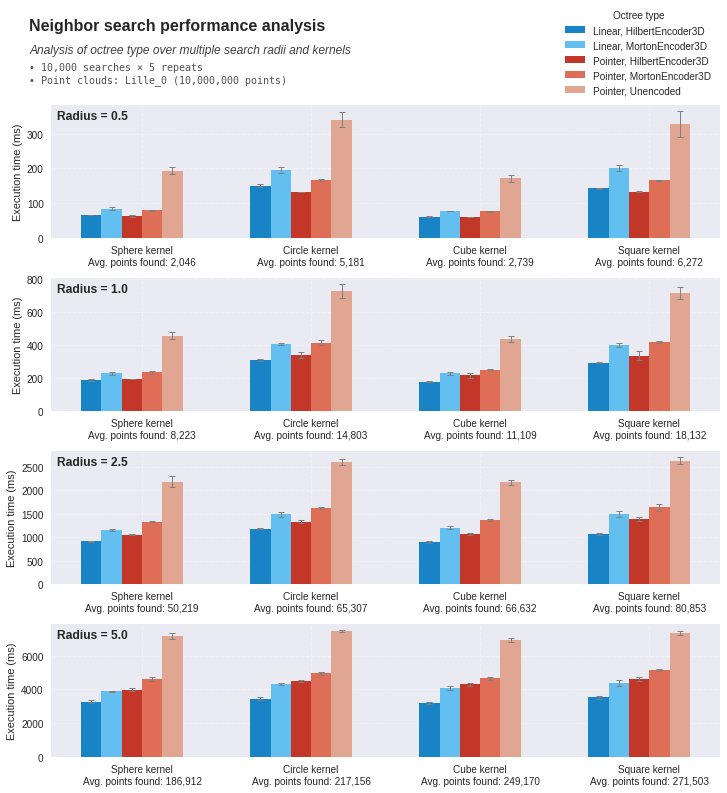

In [111]:
def octree_performance_by_radii_and_kernel(df, operation, operation_name):
    # Filter the dataset for the specified operation
    operation_df = df[df['operation'] == operation]
   
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)), 
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(parameter_combinations)
    group_gap = 0.5
   
    legend_handles, legend_labels = [], []

    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
       
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = [] 
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'{kernel} kernel\nNo data available')
                continue

            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
            
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(parameter_combinations.iterrows()):
                # Extract parameters dynamically from the row
                key = tuple(params[col] for col in OCTREE_TYPE_PARAMS)
                octree_data = kernel_data[
                    (kernel_data[OCTREE_TYPE_PARAMS] == pd.Series(key, index=OCTREE_TYPE_PARAMS)).all(axis=1)
                ]

                if octree_data.empty:
                    continue

                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                bar = ax.bar(x_pos, means[0], bar_width, 
                                color=color_dict[key])
                ax.errorbar(x_pos, means[0], stdevs[0], 
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                
                formatted_label = ", ".join(f"{value}" for param, value in zip(OCTREE_TYPE_PARAMS, key))
                if radius_idx == 0 and formatted_label not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)

        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        
        ax.text(0.01, 0.96, f'Radius = {radius}', 
                transform=ax.transAxes,
                fontsize=12, fontweight='bold',
                va='top', ha='left')
        
        ax.set_ylabel('Execution time (ms)')
    
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)

    add_title_subtitle(f"{operation_name} performance analysis", f"Analysis of octree type over multiple search radii and kernels", fig)

    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(nsearches, nrepeats, npoints, fig)

    return fig

fig = octree_performance_by_radii_and_kernel(df, 'neighSearch', 'Neighbor search')
output_fig('neighbor_perf.png', DATASET, CLOUD)

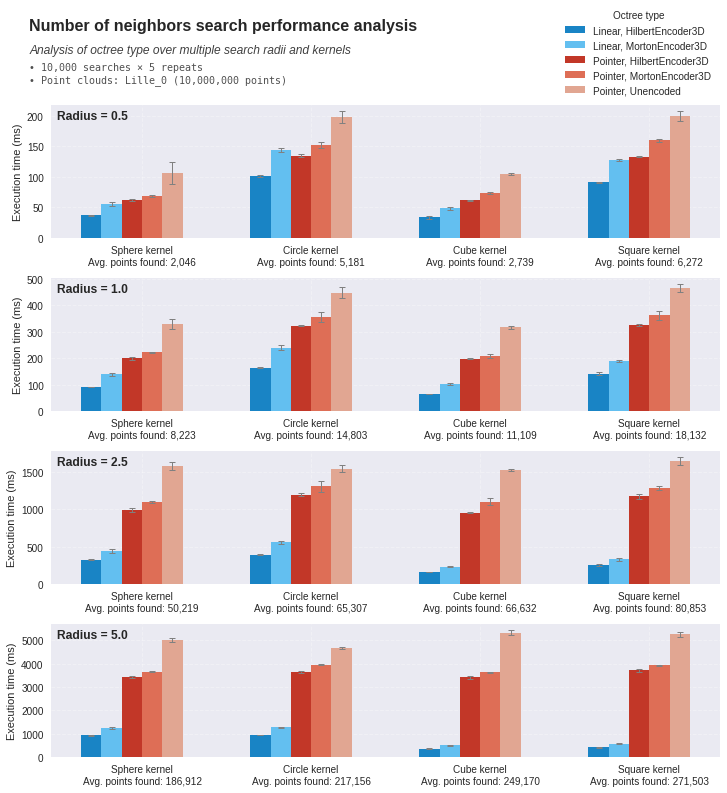

In [112]:
fig = octree_performance_by_radii_and_kernel(df, 'numNeighSearch', 'Number of neighbors search')
output_fig('num_neighbor_perf.png', CLOUD, DATASET)

In [113]:
# Load the algo_comp benchmark datasets for the comparison
BASE_DATA_FOLDER = os.path.join("out", "algo_comp")
CLOUD, DATASET = "Lille_0", "Paris_Lille"
df = get_dataset_file(CLOUD, "latest")

# The operation comparison should be done over a single octree type configuration
df_op_comparison = df[(df['octree'] == 'Linear') & (df['encoder'] == 'HilbertEncoder3D') & (df['point_type'] == "Lpoint64")]

# New palette for comparison between two operations
palette = ["#22a7f0", "#e14b31"]
print(df_op_comparison)

Loading latest file: out/algo_comp/Lille_0/Lille_0-2025-01-22-10:11:44.csv
                   date  octree point_type           encoder   npoints  \
0   2025-01-22-10:11:56  Linear   Lpoint64  HilbertEncoder3D  10000000   
1   2025-01-22-10:12:03  Linear   Lpoint64  HilbertEncoder3D  10000000   
2   2025-01-22-10:12:09  Linear   Lpoint64  HilbertEncoder3D  10000000   
3   2025-01-22-10:12:16  Linear   Lpoint64  HilbertEncoder3D  10000000   
4   2025-01-22-10:12:36  Linear   Lpoint64  HilbertEncoder3D  10000000   
..                  ...     ...        ...               ...       ...   
59  2025-01-22-10:37:35  Linear   Lpoint64  HilbertEncoder3D  10000000   
60  2025-01-22-10:37:51  Linear   Lpoint64  HilbertEncoder3D  10000000   
61  2025-01-22-10:38:05  Linear   Lpoint64  HilbertEncoder3D  10000000   
62  2025-01-22-10:38:09  Linear   Lpoint64  HilbertEncoder3D  10000000   
63  2025-01-22-10:38:14  Linear   Lpoint64  HilbertEncoder3D  10000000   

         operation  kernel  radius  

In [114]:
def plot_operation_comparison(df, operations):
    # Filter for the two operations
    df = df[df['operation'].isin(operations)]

    # Unique radii and kernels
    # Get unique radii and kernels
    radii = sorted(df['radius'].unique())
    kernels = df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)), 
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    # Bar spacing parameters
    bar_width = 0.10
    group_width = bar_width * len(operations)
    group_gap = 0.10
   
    legend_handles, legend_labels = [], []
    
    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = df[df['radius'] == radius]
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = [] 
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'{kernel} kernel\nNo data available')
                continue
            
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
            for j, operation in enumerate(operations):
                op_data = kernel_data[kernel_data["operation"] == operation]
                if op_data.empty:
                    print("Warning: No data found for operation ", operation, " in radii ", radius, " and kernel ", kernel)
                    continue
                means = op_data['mean'].values
                stdevs = op_data['stdev'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                bar = ax.bar(x_pos, means[0], bar_width, 
                                color=palette[j])
                ax.errorbar(x_pos, means[0], stdevs[0], 
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
                
                if radius_idx == 0 and operation not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(operation)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        
        ax.text(0.01, 0.96, f'Radius = {radius}', 
                transform=ax.transAxes,
                fontsize=12, fontweight='bold',
                va='top', ha='left')
        
        ax.set_ylabel('Execution time (ms)')

    add_octree_types_legend(legend_handles, legend_labels, "Operation performed", fig)
    add_title_subtitle(f"{operations[0]} vs {operations[1]} performance analysis", 
                       f"Analysis of improvement in performance after changing the search algorithm", fig)

    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(nsearches, nrepeats, npoints, fig)
    return fig



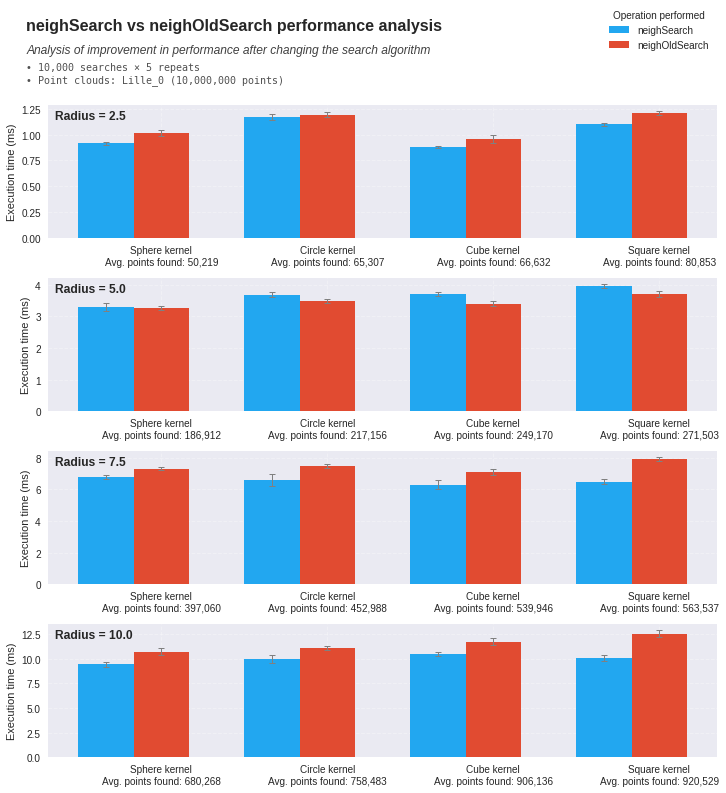

In [115]:
fig = plot_operation_comparison(df_op_comparison, ['neighSearch', 'neighOldSearch'])
plt.show()

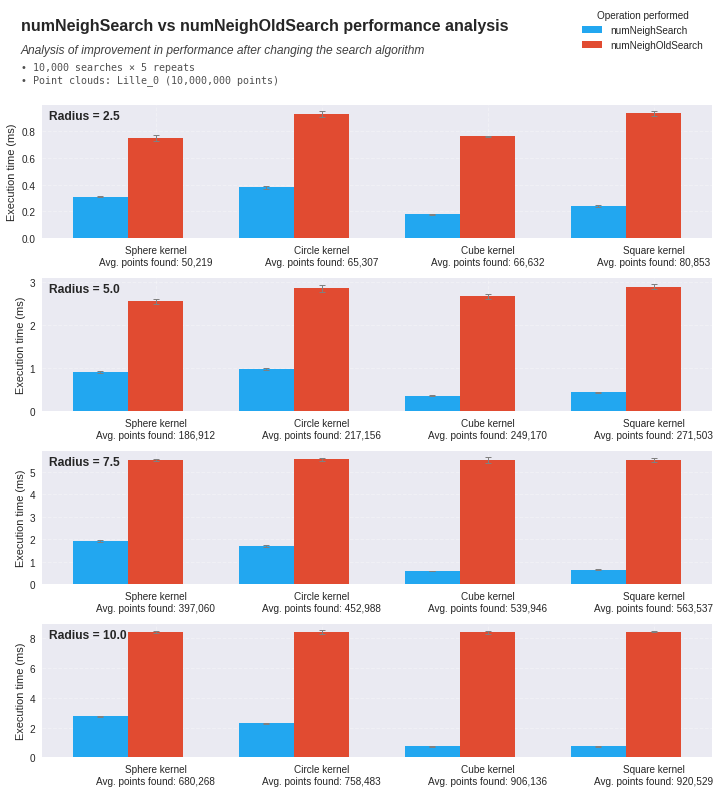

In [116]:
fig = plot_operation_comparison(df_op_comparison, ['numNeighSearch', 'numNeighOldSearch'])
plt.show()

In [117]:
# Now we load more datasets to compare the results between them and how the number of points affects the performance
BASE_DATA_FOLDER = os.path.join("out")


# Read the file and put into pandas dataframe
CLOUDS_DATASETS = {"Lille_0": "Paris_Lille", 
                #    "Lille_11": "Paris_Lille", 
                #    "Paris_Luxembourg_6": "Paris_Lille", 
                   "Speulderbos_2017_TLS": "Speulderbos"}
dfs = {}
for cloud, dataset in CLOUDS_DATASETS.items():
    df = get_dataset_file(cloud, "latest")
    # Convert times to milliseconds
    df['mean'] = df['mean'] * 1000
    df['stdev'] = df['stdev'] * 1000
    dfs[cloud] = df
len(dfs)

Loading latest file: out/Lille_0/Lille_0-2025-01-21-18:09:24.csv
Loading latest file: out/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-21-21:31:17.csv


2

In [118]:
# Ideas para plots de multiples datasets:

# 1. Fijar un kernel y una operacion, iterar por cada dataset, radio e implementación del octree
# Plottear el avg_result_size para cada par (dataset, radio) vs el tiempo de ejecución para cada implementación del octree. Una línea en un line graph
# por cada implementación del octree. Los avg_result_sizes están ordenados por tamaño, obviamente mayor radio => mayor avg_result_size, pero no necesariamente
# a través de datasets, porque la densidad varía. El problema que le veo a esta idea es que no ves cómo afecta el tamaño del dataset en el rendimiento, ya que no se
# plotea el dataset de cada avg_result_size, así que solo es una extensión de los plots que se podrían hacer con 1 solo dataframe.

# 2. Fijar kernel, radio (al máximo por ejemplo) y una operación. Iterar para cada dataframe e implementación del octree.
# Plottear tamaño del dataset vs tiempo de ejecución / avg_result_size. En cada punto del line graph debería estar el nombre del dataset para que sea fácil interpretarlo. 
# Plottear una línea para cada implementación del octree.
# Los tamaños de los datasets están ordenados y están en forma de log plot en el eje x.

# Con el segundo plot se saca como afecta el tamaño total del dataset en el tiempo por punto encontrado. Si el dataset es muy grande, habrá más fallos caché que harán
# el rendimiento peor, independientemente de la densidad del dataset/radio escogidos.

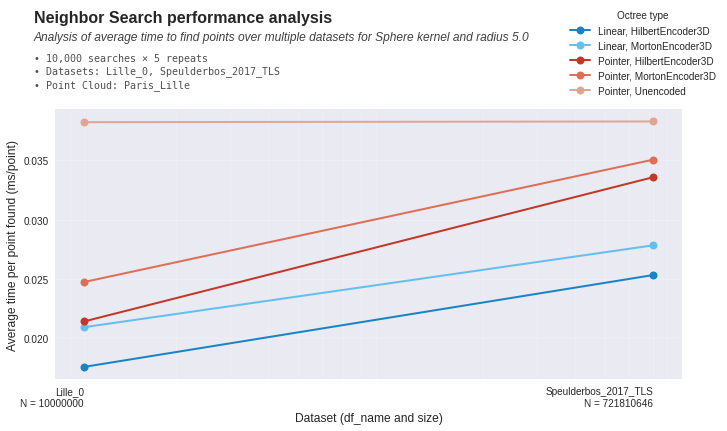

In [129]:
# Idea 2.
import numpy as np
def plot_octree_size_performance(dfs, kernel, radius, operation, operation_name):
    fig, ax = plt.subplots(figsize=(12, 6))
    implementation_data = {}
    legend_handles, legend_labels = [], []
    x_labels = []  # To store combined x-axis labels
    x_ticks = []   # To store the actual x-tick positions
    for df_name, df in dfs.items():
        df = df[(df['kernel'] == kernel) & (df['radius'] == radius) & (df['operation'] == operation)]
        avg_result_size = df['avg_result_size'].iloc[0]
        dataset_size = df['npoints'].iloc[0]
        x_labels.append(f"{df_name}\nN = {dataset_size}")
        x_ticks.append(dataset_size)
        for j, (_, params) in enumerate(parameter_combinations.iterrows()):
            key = tuple(params[col] for col in OCTREE_TYPE_PARAMS)
            impl_data = df[
                (df[OCTREE_TYPE_PARAMS] == pd.Series(key, index=OCTREE_TYPE_PARAMS)).all(axis=1)
            ]
            if impl_data.empty:
                print("Warning, no data for ", key, " with kernel = ", kernel, 
                      ", radius = ", radius, " and operation = ", operation, " at dataset ", df_name)
                
            norm_time = impl_data['mean'].iloc[0] / avg_result_size # ms / point
            if key not in implementation_data:
                implementation_data[key] = {'sizes': [], 'times': []}
            implementation_data[key]['sizes'].append(dataset_size)
            implementation_data[key]['times'].append(norm_time)

   # Plot a line for each implementation
    for key, data in implementation_data.items():
        # Sort by size to ensure proper line connection
        sizes = np.array(data['sizes'])
        times = np.array(data['times'])
        sort_idx = np.argsort(sizes)
        
        formatted_label = ", ".join(f"{value}" for value in key)
        line = ax.plot(sizes[sort_idx], times[sort_idx], 'o-', 
                      label=formatted_label, 
                      color=color_dict[key],
                      linewidth=2, markersize=8)[0]
        

        if formatted_label not in legend_labels:
            legend_handles.append(line)
            legend_labels.append(formatted_label)
    
    # Set logarithmic scale for x-axis
    ax.set_xscale('log')
    
    # Update x-axis ticks and labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=0, ha='right')

    # Labels
    ax.set_xlabel('Dataset (df_name and size)', fontsize=12)
    ax.set_ylabel('Average time per point found (ms/point)', fontsize=12)
    
    # Grid
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add all the formatting elements
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)
    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Analysis of average time to find points over multiple datasets for {kernel} kernel and radius {radius}",
        fig,
        h_title = 0.98,
        h_subtitle  = 0.93
    )
    
    # Add execution details (using the last processed dataframe's values)
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    add_execution_details_multiple_datasets(nsearches, nrepeats, dfs.keys(), fig, h_ex = 0.88)
    
    # Adjust layout
    plt.subplots_adjust(right=0.85, top=0.75)  # Make room for legend and title

    return fig

fig = plot_octree_size_performance(
    dfs=dfs,
    kernel='Sphere',
    radius=5.0,
    operation='neighSearch',
    operation_name='Neighbor Search'
)
plt.show()